In [1]:
import json
import multiprocessing
import cv2
import albumentations as A
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import pandas as pd
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime
import math
import random

from timm.utils.model_ema import ModelEmaV2

# Config

In [2]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2


class CFG:
    # ============== comp exp name =============
    comp_name = 'atmacup_18'  # comp名

    comp_dataset_path = '../raw/atmacup_18_dataset/'

    exp_name = 'atmacup_18_cnn_exp001'

    is_debug = False
    use_gray_scale = False

    model_in_chans = 9  # モデルの入力チャンネル数

    # ============== file path =============
    train_fold_dir = "../proc/baseline/folds"

    # ============== model cfg =============
    model_name = 'resnet34d'

    num_frames = 3  # model_in_chansの倍数
    norm_in_chans = 1 if use_gray_scale else 3

    use_torch_compile = False
    use_ema = True
    ema_decay = 0.995
    # ============== training cfg =============
    size = 224  # 224

    batch_size = 64  # 32

    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 20
    if is_debug:
        epochs = 2

    # adamW warmupあり
    warmup_factor = 10
    lr = 1e-3
    if scheduler == 'GradualWarmupSchedulerV2':
        lr /= warmup_factor

    # ============== fold =============
    n_fold = 5
    use_holdout = False
    use_alldata = False
    train_folds = [0, 1, 2, 3, 4]

    skf_col = 'class'
    group_col = 'scene'
    fold_type = 'gkf'

    objective_cv = 'regression'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'minimize'  # 'maximize', 'minimize'
    metrics = 'calc_mae_atmacup'

    # ============== pred target =============
    target_size = 18
    target_col = ['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2',
                  'z_2', 'x_3', 'y_3', 'z_3', 'x_4', 'y_4', 'z_4', 'x_5', 'y_5', 'z_5']


    # ============== ほぼ固定 =============
    pretrained = True
    inf_weight = 'last'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 500
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    if exp_name is not None:
        print('set dataset path')

        outputs_path = f'../proc/baseline/outputs/{exp_name}/'

        submission_dir = outputs_path + 'submissions/'
        submission_path = submission_dir + f'submission_{exp_name}.csv'

        model_dir = outputs_path + \
            f'{comp_name}-models/'

        figures_dir = outputs_path + 'figures/'

        log_dir = outputs_path + 'logs/'
        log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        # A.RandomRotate90(p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        # A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        # A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        # A.CoarseDropout(max_holes=1, max_height=int(
        #     size * 0.3), max_width=int(size * 0.3), p=0.5),

        A.Normalize(
            mean=[0] * norm_in_chans*num_frames,
            std=[1] * norm_in_chans*num_frames, 
        ),
        ToTensorV2(),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean=[0] * norm_in_chans*num_frames,
            std=[1] * norm_in_chans*num_frames,
        ),
        ToTensorV2(),
    ]

set dataset path


In [3]:
print("CUDA が利用可能か:", torch.cuda.is_available())
print("利用可能な CUDA デバイス数:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("現在の CUDA デバイス:", torch.cuda.get_device_name(0))

CUDA が利用可能か: True
利用可能な CUDA デバイス数: 1
現在の CUDA デバイス: NVIDIA GeForce RTX 3090


# make fold

In [4]:
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


def get_fold(train, cfg):
    if cfg.fold_type == 'kf':
        Fold = KFold(n_splits=cfg.n_fold,
                     shuffle=True, random_state=cfg.seed)
        kf = Fold.split(train, train[cfg.target_col])
    elif cfg.fold_type == 'skf':
        Fold = StratifiedKFold(n_splits=cfg.n_fold,
                               shuffle=True, random_state=cfg.seed)
        kf = Fold.split(train, train[cfg.skf_col])
    elif cfg.fold_type == 'gkf':
        Fold = GroupKFold(n_splits=cfg.n_fold)
        groups = train[cfg.group_col].values
        kf = Fold.split(train, train[cfg.group_col], groups)
    elif cfg.fold_type == 'sgkf':
        Fold = StratifiedGroupKFold(n_splits=cfg.n_fold,
                                    shuffle=True, random_state=cfg.seed)
        groups = train[cfg.group_col].values
        kf = Fold.split(train, train[cfg.skf_col], groups)
    # elif fold_type == 'mskf':
    #     Fold = MultilabelStratifiedKFold(
    #         n_splits=cfg.n_fold, shuffle=True, random_state=cfg.seed)
    #     kf = Fold.split(train, train[cfg.skf_col])

    for n, (train_index, val_index) in enumerate(kf):
        train.loc[val_index, 'fold'] = int(n)
    train['fold'] = train['fold'].astype(int)

    print(train.groupby('fold').size())

    return train

In [5]:
def make_train_folds():
    train_df = pd.read_csv(CFG.comp_dataset_path + 'train_features.csv')

    train_df['scene'] = train_df['ID'].str.split('_').str[0]

    print('group', CFG.group_col)
    print(f'train len: {len(train_df)}')

    train_df = get_fold(train_df, CFG)

    # print(train_df.groupby(['fold', CFG.target_col]).size())
    print(train_df['fold'].value_counts())

    os.makedirs(CFG.train_fold_dir, exist_ok=True)

    train_df.to_csv(CFG.train_fold_dir +
                    'train_folds.csv', index=False)

In [6]:
make_train_folds()

group scene
train len: 43371
fold
0    8675
1    8674
2    8674
3    8674
4    8674
dtype: int64
fold
0    8675
1    8674
2    8674
3    8674
4    8674
Name: count, dtype: int64


# setting

In [7]:
# 乱数固定
def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)

    if mode == 'train':
        make_dirs(cfg)

In [8]:
cfg_init(CFG)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# logger

In [10]:
# from common_utils.logger import init_logger, wandb_init, AverageMeter, timeSince
# from common_utils.settings import cfg_init

def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [11]:
Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------
2024年11月20日 10:47:41


# eval function

In [12]:
def get_score(y_true, y_pred):
    # return roc_auc_score(y_true, y_pred)
    eval_func = eval(CFG.metrics)
    return eval_func(y_true, y_pred)


def calc_mae_atmacup(y_true, y_pred):
    abs_diff = np.abs(y_true - y_pred)  # 各予測の差分の絶対値を計算して
    mae = np.mean(abs_diff.reshape(-1, ))  # 予測の差分の絶対値の平均を計算

    return mae

def get_result(result_df):

    # preds = result_df['preds'].values

    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]
    preds = result_df[pred_cols].values
    labels = result_df[CFG.target_col].values
    score = get_score(labels, preds)
    Logger.info(f'score: {score:<.4f}')

    return score

# image utils

In [13]:
def draw_traffic_light(image, id):
    path = f'./datasets/atmacup_18/traffic_lights/{id}.json'
    traffic_lights = json.load(open(path))

    traffic_class = ['green',
                     'straight', 'left', 'right', 'empty', 'other', 'yellow', 'red']
    class_to_idx = {
        cls: idx for idx, cls in enumerate(traffic_class)
    }

    for traffic_light in traffic_lights:
        bbox = traffic_light['bbox']
        x1, y1, x2, y2 = bbox
        # int
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        point1 = (x1, y1)
        point2 = (x2, y2)

        idx = class_to_idx[traffic_light['class']]
        color = 255 - int(255*(idx/len(traffic_class)))

        cv2.rectangle(image, point1, point2, color=color, thickness=1)

    return image


def read_image_for_cache(path):
    if CFG.use_gray_scale:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # image = cv2.resize(image, (CFG.size, CFG.size))

    # 効かない
    # image = draw_traffic_light(image, path.split('/')[-2])
    return (path, image)


def make_video_cache(paths):
    debug = []
    for idx in range(9):
        color = 255 - int(255*(idx/9))
        debug.append(color)
    print(debug)

    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        res = pool.imap_unordered(read_image_for_cache, paths)
        res = tqdm(res)
        res = list(res)

    return dict(res)

# dataset

In [14]:
from albumentations import ReplayCompose
from torch.utils.data import DataLoader, Dataset
import albumentations as A

def get_transforms(data, cfg):
    if data == 'train':
        # aug = A.Compose(cfg.train_aug_list)
        aug = A.ReplayCompose(cfg.train_aug_list)
    elif data == 'valid':
        # aug = A.Compose(cfg.valid_aug_list)
        aug = A.ReplayCompose(cfg.valid_aug_list)

    # print(aug)
    return aug


class CustomDataset(Dataset):
    def __init__(self, df, cfg, labels=None, transform=None):
        self.df = df
        self.cfg = cfg
        self.base_paths = df['base_path'].values
        # self.labels = df[self.cfg.target_col].values
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def read_image_multiframe(self, idx):
        base_path = self.base_paths[idx]

        images = []
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix

            image = self.cfg.video_cache[path]

            images.append(image)
        return images

    def __getitem__(self, idx):
        image = self.read_image_multiframe(idx)

        if self.transform:
            # image = self.transform(image=image)['image']
            replay = None
            images = []
            for img in image:
                if replay is None:
                    sample = self.transform(image=img)
                    replay = sample['replay']
                else:
                    sample = ReplayCompose.replay(replay, image=img)
                images.append(sample['image'])

            image = torch.concat(images, dim=0)

        if self.labels is None:
            return image

        if self.cfg.objective_cv == 'multiclass':
            label = torch.tensor(self.labels[idx]).long()
        else:
            label = torch.tensor(self.labels[idx]).float()

        return image, label

In [15]:
def plot_aug_video(train, cfg, plot_count=1):
    transform = CFG.train_aug_list
    transform = A.ReplayCompose(transform)

    dataset = CustomDataset(
        train, CFG, transform=transform)

    for i in range(plot_count):
        image = dataset.read_image_multiframe(i)

        if cfg.use_gray_scale:
            image = np.stack(image, axis=2)
        else:
            image = np.concatenate(image, axis=2)

        aug_image = dataset[i]
        # torch to numpy
        aug_image = aug_image.permute(1, 2, 0).numpy()*255

        for frame in range(image.shape[-1]):
            if frame % 3 != 0:
                continue

            fig, axes = plt.subplots(1, 2, figsize=(15, 6))

            if cfg.use_gray_scale:
                axes[0].imshow(image[..., frame], cmap="gray")
                axes[1].imshow(aug_image[..., frame], cmap="gray")
            else:
                axes[0].imshow(image[..., frame:frame+3].astype(int))
                axes[1].imshow(aug_image[..., frame:frame+3].astype(int))
            plt.savefig(cfg.figures_dir +
                        f'aug_{i}_frame{frame}.png')

# model

In [16]:
import timm

class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False, target_size=None, model_name=None):
        super().__init__()
        # self.cfg = cfg

        if model_name is None:
            model_name = cfg.model_name

        print(f'pretrained: {pretrained}')

        self.model = timm.create_model(
            model_name, pretrained=pretrained, num_classes=0,
            in_chans=cfg.model_in_chans)

        self.n_features = self.model.num_features

        self.target_size = cfg.target_size if target_size is None else target_size

        # nn.Dropout(0.5),
        self.fc = nn.Sequential(
            nn.Linear(self.n_features, self.target_size)
        )

    def feature(self, image):

        feature = self.model(image)
        return feature

    def forward(self, image):
        feature = self.feature(image)
        output = self.fc(feature)
        return output

# scheduler

In [17]:
import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    if cfg.scheduler == 'ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(
            optimizer, mode='min', factor=cfg.factor, patience=cfg.patience, verbose=True, eps=cfg.eps)
    elif cfg.scheduler == 'CosineAnnealingLR':
        scheduler = CosineAnnealingLR(
            optimizer, T_max=cfg.epochs, eta_min=cfg.min_lr, last_epoch=-1)
    elif cfg.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer, T_0=cfg.T_0, T_mult=1, eta_min=cfg.min_lr, last_epoch=-1)
    elif cfg.scheduler == 'GradualWarmupSchedulerV2':
        scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, cfg.epochs, eta_min=1e-7)
        scheduler = GradualWarmupSchedulerV2(
            optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()
    elif isinstance(scheduler, CosineAnnealingWarmRestarts):
        scheduler.step()
    elif isinstance(scheduler, GradualWarmupSchedulerV2):
        scheduler.step(epoch)

# train

In [18]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device,
             model_ema=None):
    """ 1epoch毎のtrain """

    model.train()
    scaler = GradScaler(enabled=CFG.use_amp)

    losses = AverageMeter()
    preds = []
    preds_labels = []
    start = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)

            if y_preds.size(1) == 1:
                y_preds = y_preds.view(-1)

            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()

        if model_ema is not None:
            model_ema.update(model)

        optimizer.zero_grad()
        global_step += 1

        if CFG.objective_cv == 'binary':
            preds.append(torch.sigmoid(y_preds).detach().to('cpu').numpy())
        elif CFG.objective_cv == 'multiclass':
            preds.append(y_preds.softmax(1).detach().to('cpu').numpy())
        elif CFG.objective_cv == 'regression':
            preds.append(y_preds.detach().to('cpu').numpy())

        preds_labels.append(labels.detach().to('cpu').numpy())

        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(epoch + 1, step, len(train_loader),
                          remain=timeSince(start, float(
                              step + 1) / len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
    predictions = np.concatenate(preds)
    labels = np.concatenate(preds_labels)
    return losses.avg, predictions, labels


def valid_fn(valid_loader, model, criterion, device):

    model.eval()
    losses = AverageMeter()
    preds = []
    start = time.time()

    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)

        if y_preds.size(1) == 1:
            y_preds = y_preds.view(-1)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # binary
        if CFG.objective_cv == 'binary':
            preds.append(torch.sigmoid(y_preds).to('cpu').numpy())
        elif CFG.objective_cv == 'multiclass':
            preds.append(y_preds.softmax(1).to('cpu').numpy())
        elif CFG.objective_cv == 'regression':
            preds.append(y_preds.to('cpu').numpy())

        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step + 1) / len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [19]:
def train_fold(folds, fold):

    Logger.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    if CFG.use_alldata:
        train_folds = folds.copy().reset_index(drop=True)
    else:
        train_folds = folds.loc[trn_idx].reset_index(drop=True)

    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    # train_folds = train_downsampling(train_folds)

    train_labels = train_folds[CFG.target_col].values
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = CustomDataset(
        train_folds, CFG, labels=train_labels, transform=get_transforms(data='train', cfg=CFG))
    valid_dataset = CustomDataset(
        valid_folds, CFG, labels=valid_labels, transform=get_transforms(data='valid', cfg=CFG))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                              )
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================

    model = CustomModel(CFG, pretrained=CFG.pretrained)
    model.to(device)

    if CFG.use_ema:
        model_ema = ModelEmaV2(model, decay=CFG.ema_decay)
    else:
        model_ema = None

    optimizer = AdamW(model.parameters(), lr=CFG.lr)
    scheduler = get_scheduler(CFG, optimizer)

    # ====================================================
    # loop
    # ====================================================
    if CFG.objective_cv == 'binary':
        criterion = nn.BCEWithLogitsLoss()
    elif CFG.objective_cv == 'multiclass':
        criterion = nn.CrossEntropyLoss()
    elif CFG.objective_cv == 'regression':
        criterion = nn.L1Loss()

    if CFG.metric_direction == 'minimize':
        best_score = np.inf
    elif CFG.metric_direction == 'maximize':
        best_score = -1

    best_loss = np.inf

    df_score = pd.DataFrame(columns=["train_loss", 'train_score', 'val_loss', 'val_score'])

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss, train_preds, train_labels_epoch = train_fn(fold, train_loader, model,
                                                             criterion, optimizer, epoch, scheduler, device, model_ema)
        train_score = get_score(train_labels_epoch, train_preds)

        # eval
        if model_ema is not None:
            avg_val_loss, valid_preds = valid_fn(
                valid_loader, model_ema.module, criterion, device)
        else:
            avg_val_loss, valid_preds = valid_fn(
                valid_loader, model, criterion, device)

        scheduler_step(scheduler, avg_val_loss, epoch)

        # scoring
        score = get_score(valid_labels, valid_preds)

        elapsed = time.time() - start_time

        Logger.info(
            f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
        Logger.info(
            f'Epoch {epoch+1} - avg_train_Score: {train_score:.4f} avgScore: {score:.4f}')
        
        df_score.loc[epoch] = [avg_loss, train_score, avg_val_loss, score]

        if CFG.metric_direction == 'minimize':
            update_best = score < best_score
        elif CFG.metric_direction == 'maximize':
            update_best = score > best_score

        if update_best:
            best_loss = avg_val_loss
            best_score = score

            Logger.info(
                f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            Logger.info(
                f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')

            if model_ema is not None:
                torch.save({'model': model_ema.module.state_dict(),
                            'preds': valid_preds},
                           CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')
            else:
                torch.save({'model': model.state_dict(),
                            'preds': valid_preds},
                           CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

    """
    torch.save({'model': model.state_dict(),
                'preds': valid_preds},
               CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')
    """
    if model_ema is not None:
        torch.save({'model': model_ema.module.state_dict(),
                    'preds': valid_preds},
                   CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')
    else:
        torch.save({'model': model.state_dict(),
                    'preds': valid_preds},
                   CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')

    check_point = torch.load(
        CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))
    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]

    check_point_pred = check_point['preds']

    # Columns must be same length as key 対策
    if check_point_pred.ndim == 1:
        check_point_pred = check_point_pred.reshape(-1, CFG.target_size)

    print('check_point_pred shape', check_point_pred.shape)
    valid_folds[pred_cols] = check_point_pred
    return valid_folds, df_score

# train main

In [20]:
def main():
    train = pd.read_csv(CFG.train_fold_dir + 'train_folds.csv')
    train['ori_idx'] = train.index

    train['scene'] = train['ID'].str.split('_').str[0]

    """
    if CFG.is_debug:
        use_ids = train['scene'].unique()[:100]
        train = train[train['scene'].isin(use_ids)].reset_index(drop=True)
    """

    train['base_path'] = CFG.comp_dataset_path + 'images/' + train['ID'] + '/'

    paths = []
    for base_path in train['base_path'].values:
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix
            paths.append(path)

    print(paths[:5])

    CFG.video_cache = make_video_cache(paths)

    # plot_aug_video(train, CFG, plot_count=10)

    # train
    oof_df = pd.DataFrame()
    list_df_score = []
    for fold in range(CFG.n_fold):
        if fold not in CFG.train_folds:
            print(f'fold {fold} is skipped')
            continue

        _oof_df, _df_score = train_fold(train, fold)
        oof_df = pd.concat([oof_df, _oof_df])
        list_df_score.append(_df_score)
        Logger.info(f"========== fold: {fold} result ==========")
        get_result(_oof_df)

        if CFG.use_holdout or CFG.use_alldata:
            break

    oof_df = oof_df.sort_values('ori_idx').reset_index(drop=True)

    # CV result
    Logger.info("========== CV ==========")
    score = get_result(oof_df)

    # 学習曲線を可視化する
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    for df_score in list_df_score:
        ax1.plot(df_score['val_loss'])
        ax2.plot(df_score['val_score'])
    ax1.set_title('Validation Loss')
    ax2.set_title('Validation Score') 
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Score')
    plt.tight_layout()
    plt.savefig(CFG.figures_dir + f'learning_curve_{CFG.exp_name}.png')
    plt.show()

    # save result
    oof_df.to_csv(CFG.submission_dir + 'oof_cv.csv', index=False)

['../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t-1.0.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t-0.5.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_420/image_t-1.0.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_420/image_t-0.5.png']
[255, 227, 199, 170, 142, 114, 85, 57, 29]


0it [00:00, ?it/s]

========== fold: 0 training ==========


pretrained: True


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 2s (remain 19m 28s) Loss: 6.0161(6.0161) Grad: 90772.9375  LR: 0.000100  
Epoch: [1][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.3780(2.2970) Grad: 287529.7500  LR: 0.000100  
Epoch: [1][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.5147(2.2217) Grad: 305098.0625  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 1.9239(1.9239) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.2217  avg_val_loss: 2.0092  time: 64s
Epoch 1 - avg_train_Score: 2.2217 avgScore: 2.0092
Epoch 1 - Save Best Score: 2.0092 Model
Epoch 1 - Save Best Loss: 2.0092 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 2.0313(2.0092) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 0s (remain 8m 14s) Loss: 1.1568(1.1568) Grad: 202497.3438  LR: 0.000100  
Epoch: [2][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 1.1710(1.1373) Grad: 121837.5625  LR: 0.000100  
Epoch: [2][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 1.1150(1.1297) Grad: 119889.8125  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 14s) Loss: 1.2549(1.2549) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.1297  avg_val_loss: 1.0486  time: 63s
Epoch 2 - avg_train_Score: 1.1297 avgScore: 1.0486
Epoch 2 - Save Best Score: 1.0486 Model
Epoch 2 - Save Best Loss: 1.0486 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0585(1.0486) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 0s (remain 7m 53s) Loss: 0.8621(0.8621) Grad: 262067.7812  LR: 0.001000  
Epoch: [3][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.0856(1.1898) Grad: 170080.3281  LR: 0.001000  
Epoch: [3][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7892(1.1812) Grad: 167275.8594  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 1.0019(1.0019) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.1812  avg_val_loss: 0.9690  time: 64s
Epoch 3 - avg_train_Score: 1.1812 avgScore: 0.9690
Epoch 3 - Save Best Score: 0.9690 Model
Epoch 3 - Save Best Loss: 0.9690 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.9076(0.9690) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 0s (remain 8m 7s) Loss: 1.0897(1.0897) Grad: 191977.9844  LR: 0.001000  
Epoch: [4][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.0539(1.0279) Grad: 168259.6094  LR: 0.001000  
Epoch: [4][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.8965(1.0266) Grad: 155250.8594  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 13s) Loss: 0.9381(0.9381) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0266  avg_val_loss: 0.9124  time: 63s
Epoch 4 - avg_train_Score: 1.0266 avgScore: 0.9124
Epoch 4 - Save Best Score: 0.9124 Model
Epoch 4 - Save Best Loss: 0.9124 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8868(0.9124) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 9m 19s) Loss: 1.0065(1.0065) Grad: 199316.5781  LR: 0.000958  
Epoch: [5][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.9546(0.9292) Grad: 154591.5781  LR: 0.000958  
Epoch: [5][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.8873(0.9304) Grad: 137796.4375  LR: 0.000958  
EVAL: [0/68] Elapsed 0m 0s (remain 1m 6s) Loss: 0.9216(0.9216) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.9304  avg_val_loss: 0.8726  time: 63s
Epoch 5 - avg_train_Score: 0.9304 avgScore: 0.8726
Epoch 5 - Save Best Score: 0.8726 Model
Epoch 5 - Save Best Loss: 0.8726 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8534(0.8726) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 0s (remain 8m 57s) Loss: 0.8022(0.8022) Grad: 152952.0000  LR: 0.000916  
Epoch: [6][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.8121(0.8500) Grad: 154055.9375  LR: 0.000916  
Epoch: [6][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.9564(0.8530) Grad: 123356.1719  LR: 0.000916  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 16s) Loss: 0.8873(0.8873) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8530  avg_val_loss: 0.8259  time: 64s
Epoch 6 - avg_train_Score: 0.8530 avgScore: 0.8259
Epoch 6 - Save Best Score: 0.8259 Model
Epoch 6 - Save Best Loss: 0.8259 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7638(0.8259) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 0s (remain 9m 0s) Loss: 0.8494(0.8494) Grad: 161426.8594  LR: 0.000865  
Epoch: [7][500/542] Elapsed 0m 52s (remain 0m 4s) Loss: 0.7999(0.7840) Grad: 154799.8906  LR: 0.000865  
Epoch: [7][541/542] Elapsed 0m 56s (remain 0m 0s) Loss: 0.6900(0.7834) Grad: 113204.9141  LR: 0.000865  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.8194(0.8194) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.7834  avg_val_loss: 0.7981  time: 66s
Epoch 7 - avg_train_Score: 0.7834 avgScore: 0.7981
Epoch 7 - Save Best Score: 0.7981 Model
Epoch 7 - Save Best Loss: 0.7981 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7804(0.7981) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 0s (remain 8m 13s) Loss: 0.7881(0.7881) Grad: 170341.1719  LR: 0.000805  
Epoch: [8][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.7022(0.7217) Grad: 97145.4141  LR: 0.000805  
Epoch: [8][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.6271(0.7224) Grad: 126874.2812  LR: 0.000805  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 11s) Loss: 0.8032(0.8032) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7224  avg_val_loss: 0.7740  time: 63s
Epoch 8 - avg_train_Score: 0.7224 avgScore: 0.7740
Epoch 8 - Save Best Score: 0.7740 Model
Epoch 8 - Save Best Loss: 0.7740 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7225(0.7740) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 0s (remain 8m 12s) Loss: 0.5716(0.5716) Grad: 89455.4375  LR: 0.000738  
Epoch: [9][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.6524(0.6543) Grad: 122123.6562  LR: 0.000738  
Epoch: [9][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.6482(0.6555) Grad: 113315.9297  LR: 0.000738  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 11s) Loss: 0.7497(0.7497) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6555  avg_val_loss: 0.7421  time: 63s
Epoch 9 - avg_train_Score: 0.6555 avgScore: 0.7421
Epoch 9 - Save Best Score: 0.7421 Model
Epoch 9 - Save Best Loss: 0.7421 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6719(0.7421) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 0s (remain 8m 18s) Loss: 0.5516(0.5516) Grad: 99624.1641  LR: 0.000666  
Epoch: [10][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.5716(0.5892) Grad: 78483.9531  LR: 0.000666  
Epoch: [10][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.6081(0.5913) Grad: 140051.5938  LR: 0.000666  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 8s) Loss: 0.7363(0.7363) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.5913  avg_val_loss: 0.7247  time: 63s
Epoch 10 - avg_train_Score: 0.5913 avgScore: 0.7247
Epoch 10 - Save Best Score: 0.7247 Model
Epoch 10 - Save Best Loss: 0.7247 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6170(0.7247) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 0s (remain 7m 54s) Loss: 0.6316(0.6316) Grad: 149523.9844  LR: 0.000589  
Epoch: [11][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5809(0.5367) Grad: 102155.3359  LR: 0.000589  
Epoch: [11][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4018(0.5362) Grad: 91119.5312  LR: 0.000589  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 15s) Loss: 0.7251(0.7251) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.5362  avg_val_loss: 0.7145  time: 63s
Epoch 11 - avg_train_Score: 0.5362 avgScore: 0.7145
Epoch 11 - Save Best Score: 0.7145 Model
Epoch 11 - Save Best Loss: 0.7145 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6562(0.7145) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 0s (remain 8m 15s) Loss: 0.5264(0.5264) Grad: 82775.2500  LR: 0.000511  
Epoch: [12][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5514(0.4844) Grad: 132973.5938  LR: 0.000511  
Epoch: [12][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4546(0.4859) Grad: 95669.1328  LR: 0.000511  
EVAL: [0/68] Elapsed 0m 0s (remain 1m 6s) Loss: 0.7146(0.7146) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.4859  avg_val_loss: 0.7114  time: 63s
Epoch 12 - avg_train_Score: 0.4859 avgScore: 0.7114
Epoch 12 - Save Best Score: 0.7114 Model
Epoch 12 - Save Best Loss: 0.7114 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6424(0.7114) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 0s (remain 8m 28s) Loss: 0.4121(0.4121) Grad: 98504.6250  LR: 0.000432  
Epoch: [13][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.3940(0.4367) Grad: 93288.1641  LR: 0.000432  
Epoch: [13][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.4534(0.4376) Grad: 120355.1641  LR: 0.000432  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 15s) Loss: 0.7156(0.7156) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.4376  avg_val_loss: 0.7072  time: 63s
Epoch 13 - avg_train_Score: 0.4376 avgScore: 0.7072
Epoch 13 - Save Best Score: 0.7072 Model
Epoch 13 - Save Best Loss: 0.7072 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6509(0.7072) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 0s (remain 8m 3s) Loss: 0.4076(0.4076) Grad: 112083.4219  LR: 0.000356  
Epoch: [14][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3938(0.3927) Grad: 121882.8281  LR: 0.000356  
Epoch: [14][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3921(0.3914) Grad: 94764.0078  LR: 0.000356  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 0.7101(0.7101) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.3914  avg_val_loss: 0.7047  time: 63s
Epoch 14 - avg_train_Score: 0.3914 avgScore: 0.7047
Epoch 14 - Save Best Score: 0.7047 Model
Epoch 14 - Save Best Loss: 0.7047 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6483(0.7047) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 0s (remain 8m 11s) Loss: 0.3570(0.3570) Grad: 93384.8750  LR: 0.000283  
Epoch: [15][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.3635(0.3530) Grad: 85204.3125  LR: 0.000283  
Epoch: [15][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2932(0.3522) Grad: 74394.2344  LR: 0.000283  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 7s) Loss: 0.7115(0.7115) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.3522  avg_val_loss: 0.7038  time: 63s
Epoch 15 - avg_train_Score: 0.3522 avgScore: 0.7038
Epoch 15 - Save Best Score: 0.7038 Model
Epoch 15 - Save Best Loss: 0.7038 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6752(0.7038) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 0s (remain 8m 55s) Loss: 0.3414(0.3414) Grad: 82356.6797  LR: 0.000216  
Epoch: [16][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3001(0.3170) Grad: 73174.5859  LR: 0.000216  
Epoch: [16][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3151(0.3166) Grad: 77452.3125  LR: 0.000216  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 12s) Loss: 0.7015(0.7015) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.3166  avg_val_loss: 0.7021  time: 64s
Epoch 16 - avg_train_Score: 0.3166 avgScore: 0.7021
Epoch 16 - Save Best Score: 0.7021 Model
Epoch 16 - Save Best Loss: 0.7021 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6744(0.7021) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 0s (remain 8m 31s) Loss: 0.2993(0.2993) Grad: 136179.1250  LR: 0.000156  
Epoch: [17][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2967(0.2809) Grad: 56872.6367  LR: 0.000156  
Epoch: [17][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.2831(0.2801) Grad: 107113.6719  LR: 0.000156  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 8s) Loss: 0.6886(0.6886) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.2801  avg_val_loss: 0.7021  time: 64s
Epoch 17 - avg_train_Score: 0.2801 avgScore: 0.7021


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6636(0.7021) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 0s (remain 8m 32s) Loss: 0.3153(0.3153) Grad: 88685.2656  LR: 0.000104  
Epoch: [18][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2706(0.2535) Grad: 82293.5000  LR: 0.000104  
Epoch: [18][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2296(0.2529) Grad: 70937.5781  LR: 0.000104  
EVAL: [0/68] Elapsed 0m 0s (remain 1m 6s) Loss: 0.6989(0.6989) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.2529  avg_val_loss: 0.7032  time: 62s
Epoch 18 - avg_train_Score: 0.2529 avgScore: 0.7032


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6581(0.7032) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 0s (remain 8m 17s) Loss: 0.2863(0.2863) Grad: 62585.7305  LR: 0.000062  
Epoch: [19][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2098(0.2292) Grad: 76439.1016  LR: 0.000062  
Epoch: [19][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2634(0.2294) Grad: 101143.3750  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 13s) Loss: 0.7006(0.7006) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.2294  avg_val_loss: 0.7021  time: 62s
Epoch 19 - avg_train_Score: 0.2294 avgScore: 0.7021


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6512(0.7021) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 0s (remain 8m 22s) Loss: 0.1966(0.1966) Grad: 52666.6562  LR: 0.000031  
Epoch: [20][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2085(0.2087) Grad: 93049.0156  LR: 0.000031  
Epoch: [20][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2099(0.2089) Grad: 76769.8281  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 10s) Loss: 0.6974(0.6974) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.2089  avg_val_loss: 0.7024  time: 64s
Epoch 20 - avg_train_Score: 0.2089 avgScore: 0.7024


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6493(0.7024) 


/tmp/ipykernel_34009/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 0 result ==========
score: 0.7024
==========

check_point_pred shape (8675, 18)
pretrained: True


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 0s (remain 8m 29s) Loss: 5.5328(5.5328) Grad: 85208.7734  LR: 0.000100  
Epoch: [1][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.3448(2.2981) Grad: 250248.2812  LR: 0.000100  
Epoch: [1][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.1757(2.2216) Grad: 254167.7344  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 2.1033(2.1033) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.2216  avg_val_loss: 1.9290  time: 64s
Epoch 1 - avg_train_Score: 2.2216 avgScore: 1.9290
Epoch 1 - Save Best Score: 1.9290 Model
Epoch 1 - Save Best Loss: 1.9290 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 1.7395(1.9290) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 0s (remain 8m 31s) Loss: 1.3240(1.3240) Grad: inf  LR: 0.000100  
Epoch: [2][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.8652(1.1372) Grad: 134001.2500  LR: 0.000100  
Epoch: [2][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.3922(1.1326) Grad: 151618.9844  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 13s) Loss: 1.1266(1.1266) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.1326  avg_val_loss: 1.0070  time: 64s
Epoch 2 - avg_train_Score: 1.1326 avgScore: 1.0070
Epoch 2 - Save Best Score: 1.0070 Model
Epoch 2 - Save Best Loss: 1.0070 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.9755(1.0070) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 0s (remain 8m 28s) Loss: 1.0822(1.0822) Grad: 311079.8125  LR: 0.001000  
Epoch: [3][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.0697(1.2026) Grad: 152168.9688  LR: 0.001000  
Epoch: [3][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.1294(1.1977) Grad: 201825.3438  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 1.0645(1.0645) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.1977  avg_val_loss: 0.9706  time: 63s
Epoch 3 - avg_train_Score: 1.1977 avgScore: 0.9706
Epoch 3 - Save Best Score: 0.9706 Model
Epoch 3 - Save Best Loss: 0.9706 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.9843(0.9706) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 0s (remain 8m 23s) Loss: 1.3892(1.3892) Grad: 254762.0781  LR: 0.001000  
Epoch: [4][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.9814(1.0244) Grad: 167730.6562  LR: 0.001000  
Epoch: [4][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.9789(1.0266) Grad: 157753.9531  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.9840(0.9840) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0266  avg_val_loss: 0.8923  time: 65s
Epoch 4 - avg_train_Score: 1.0266 avgScore: 0.8923
Epoch 4 - Save Best Score: 0.8923 Model
Epoch 4 - Save Best Loss: 0.8923 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8999(0.8923) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 0s (remain 8m 11s) Loss: 0.7891(0.7891) Grad: 158671.5312  LR: 0.000958  
Epoch: [5][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.9757(0.9388) Grad: 172552.0781  LR: 0.000958  
Epoch: [5][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.8125(0.9378) Grad: 175565.6250  LR: 0.000958  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 10s) Loss: 0.9063(0.9063) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.9378  avg_val_loss: 0.8582  time: 64s
Epoch 5 - avg_train_Score: 0.9378 avgScore: 0.8582
Epoch 5 - Save Best Score: 0.8582 Model
Epoch 5 - Save Best Loss: 0.8582 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8578(0.8582) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 0s (remain 8m 32s) Loss: 1.0207(1.0207) Grad: 150554.1250  LR: 0.000916  
Epoch: [6][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.7692(0.8668) Grad: 139762.9375  LR: 0.000916  
Epoch: [6][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.0060(0.8694) Grad: 145947.0156  LR: 0.000916  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 13s) Loss: 0.9080(0.9080) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8694  avg_val_loss: 0.8212  time: 64s
Epoch 6 - avg_train_Score: 0.8694 avgScore: 0.8212
Epoch 6 - Save Best Score: 0.8212 Model
Epoch 6 - Save Best Loss: 0.8212 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8307(0.8212) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 0s (remain 8m 41s) Loss: 0.6726(0.6726) Grad: 140289.3281  LR: 0.000865  
Epoch: [7][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.9535(0.8015) Grad: 145186.7656  LR: 0.000865  
Epoch: [7][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.6324(0.8004) Grad: 110990.3438  LR: 0.000865  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.8248(0.8248) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.8004  avg_val_loss: 0.7878  time: 64s
Epoch 7 - avg_train_Score: 0.8004 avgScore: 0.7878
Epoch 7 - Save Best Score: 0.7878 Model
Epoch 7 - Save Best Loss: 0.7878 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8214(0.7878) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 0s (remain 8m 15s) Loss: 0.9865(0.9865) Grad: 131584.5469  LR: 0.000805  
Epoch: [8][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.8070(0.7323) Grad: 143128.5781  LR: 0.000805  
Epoch: [8][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.7158(0.7317) Grad: 86136.3984  LR: 0.000805  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 13s) Loss: 0.7937(0.7937) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7317  avg_val_loss: 0.7601  time: 63s
Epoch 8 - avg_train_Score: 0.7317 avgScore: 0.7601
Epoch 8 - Save Best Score: 0.7601 Model
Epoch 8 - Save Best Loss: 0.7601 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7710(0.7601) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 0s (remain 8m 14s) Loss: 0.7245(0.7245) Grad: 135072.9688  LR: 0.000738  
Epoch: [9][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.7511(0.6601) Grad: 124682.6953  LR: 0.000738  
Epoch: [9][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7205(0.6629) Grad: 91373.8906  LR: 0.000738  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 11s) Loss: 0.8041(0.8041) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6629  avg_val_loss: 0.7359  time: 64s
Epoch 9 - avg_train_Score: 0.6629 avgScore: 0.7359
Epoch 9 - Save Best Score: 0.7359 Model
Epoch 9 - Save Best Loss: 0.7359 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7707(0.7359) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 0s (remain 8m 35s) Loss: 0.5685(0.5685) Grad: 105637.3438  LR: 0.000666  
Epoch: [10][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4789(0.6081) Grad: 83880.4453  LR: 0.000666  
Epoch: [10][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5474(0.6085) Grad: 96076.3750  LR: 0.000666  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.7739(0.7739) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.6085  avg_val_loss: 0.7220  time: 64s
Epoch 10 - avg_train_Score: 0.6085 avgScore: 0.7220
Epoch 10 - Save Best Score: 0.7220 Model
Epoch 10 - Save Best Loss: 0.7220 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7261(0.7220) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 0s (remain 8m 19s) Loss: 0.5446(0.5446) Grad: 93554.1641  LR: 0.000589  
Epoch: [11][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.5494(0.5419) Grad: 100519.2578  LR: 0.000589  
Epoch: [11][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.5856(0.5430) Grad: 107060.0469  LR: 0.000589  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.7814(0.7814) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.5430  avg_val_loss: 0.7150  time: 63s
Epoch 11 - avg_train_Score: 0.5430 avgScore: 0.7150
Epoch 11 - Save Best Score: 0.7150 Model
Epoch 11 - Save Best Loss: 0.7150 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7305(0.7150) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 0s (remain 8m 31s) Loss: 0.5177(0.5177) Grad: 104095.2656  LR: 0.000511  
Epoch: [12][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4178(0.4985) Grad: 101212.6094  LR: 0.000511  
Epoch: [12][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5229(0.4994) Grad: 91562.6719  LR: 0.000511  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 10s) Loss: 0.7194(0.7194) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.4994  avg_val_loss: 0.7074  time: 63s
Epoch 12 - avg_train_Score: 0.4994 avgScore: 0.7074
Epoch 12 - Save Best Score: 0.7074 Model
Epoch 12 - Save Best Loss: 0.7074 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6884(0.7074) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 0s (remain 8m 37s) Loss: 0.4021(0.4021) Grad: 116400.2422  LR: 0.000432  
Epoch: [13][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4875(0.4481) Grad: 109782.0703  LR: 0.000432  
Epoch: [13][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5302(0.4486) Grad: 141663.3750  LR: 0.000432  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 13s) Loss: 0.7293(0.7293) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.4486  avg_val_loss: 0.7034  time: 64s
Epoch 13 - avg_train_Score: 0.4486 avgScore: 0.7034
Epoch 13 - Save Best Score: 0.7034 Model
Epoch 13 - Save Best Loss: 0.7034 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7041(0.7034) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 0s (remain 8m 22s) Loss: 0.5044(0.5044) Grad: 116550.2188  LR: 0.000356  
Epoch: [14][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4191(0.4024) Grad: 83224.2734  LR: 0.000356  
Epoch: [14][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3826(0.4025) Grad: 85218.5859  LR: 0.000356  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 11s) Loss: 0.7301(0.7301) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.4025  avg_val_loss: 0.6967  time: 64s
Epoch 14 - avg_train_Score: 0.4025 avgScore: 0.6967
Epoch 14 - Save Best Score: 0.6967 Model
Epoch 14 - Save Best Loss: 0.6967 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7042(0.6967) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 0s (remain 8m 31s) Loss: 0.3684(0.3684) Grad: 99323.9141  LR: 0.000283  
Epoch: [15][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3332(0.3618) Grad: 66335.7578  LR: 0.000283  
Epoch: [15][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4026(0.3612) Grad: 82430.5312  LR: 0.000283  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 0.7427(0.7427) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.3612  avg_val_loss: 0.6970  time: 64s
Epoch 15 - avg_train_Score: 0.3612 avgScore: 0.6970


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7128(0.6970) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 0s (remain 8m 21s) Loss: 0.3578(0.3578) Grad: 88281.1094  LR: 0.000216  
Epoch: [16][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.3218(0.3221) Grad: 71674.8516  LR: 0.000216  
Epoch: [16][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2675(0.3221) Grad: 80354.0391  LR: 0.000216  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 12s) Loss: 0.7404(0.7404) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.3221  avg_val_loss: 0.6926  time: 63s
Epoch 16 - avg_train_Score: 0.3221 avgScore: 0.6926
Epoch 16 - Save Best Score: 0.6926 Model
Epoch 16 - Save Best Loss: 0.6926 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7319(0.6926) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 0s (remain 8m 31s) Loss: 0.2811(0.2811) Grad: 49732.4648  LR: 0.000156  
Epoch: [17][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2706(0.2906) Grad: 60689.2070  LR: 0.000156  
Epoch: [17][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2709(0.2907) Grad: 62121.8125  LR: 0.000156  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.7432(0.7432) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.2907  avg_val_loss: 0.6908  time: 64s
Epoch 17 - avg_train_Score: 0.2907 avgScore: 0.6908
Epoch 17 - Save Best Score: 0.6908 Model
Epoch 17 - Save Best Loss: 0.6908 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7227(0.6908) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 0s (remain 8m 29s) Loss: 0.2523(0.2523) Grad: 88194.8828  LR: 0.000104  
Epoch: [18][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2491(0.2584) Grad: 73155.7656  LR: 0.000104  
Epoch: [18][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2636(0.2586) Grad: 78051.5156  LR: 0.000104  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 10s) Loss: 0.7390(0.7390) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.2586  avg_val_loss: 0.6916  time: 63s
Epoch 18 - avg_train_Score: 0.2586 avgScore: 0.6916


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7249(0.6916) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 0s (remain 8m 37s) Loss: 0.2481(0.2481) Grad: 67461.6641  LR: 0.000062  
Epoch: [19][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2105(0.2330) Grad: 80246.4297  LR: 0.000062  
Epoch: [19][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2294(0.2333) Grad: 75704.8672  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 8s) Loss: 0.7412(0.7412) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.2333  avg_val_loss: 0.6919  time: 63s
Epoch 19 - avg_train_Score: 0.2333 avgScore: 0.6919


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7101(0.6919) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 0s (remain 8m 31s) Loss: 0.2316(0.2316) Grad: 72623.6406  LR: 0.000031  
Epoch: [20][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2173(0.2164) Grad: 65297.3711  LR: 0.000031  
Epoch: [20][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2210(0.2166) Grad: 80831.3359  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 10s) Loss: 0.7476(0.7476) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.2166  avg_val_loss: 0.6917  time: 63s
Epoch 20 - avg_train_Score: 0.2166 avgScore: 0.6917


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7196(0.6917) 


/tmp/ipykernel_34009/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 1 result ==========
score: 0.6917
==========

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 0s (remain 8m 27s) Loss: 6.3900(6.3900) Grad: 87051.9219  LR: 0.000100  
Epoch: [1][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.4557(2.2803) Grad: 318714.0938  LR: 0.000100  
Epoch: [1][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.3035(2.2032) Grad: 299538.0312  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 2.0007(2.0007) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.2032  avg_val_loss: 2.1200  time: 63s
Epoch 1 - avg_train_Score: 2.2032 avgScore: 2.1200
Epoch 1 - Save Best Score: 2.1200 Model
Epoch 1 - Save Best Loss: 2.1200 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 2.0169(2.1200) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 0s (remain 8m 47s) Loss: 1.4982(1.4982) Grad: 314279.6250  LR: 0.000100  
Epoch: [2][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.9782(1.1611) Grad: 122488.0312  LR: 0.000100  
Epoch: [2][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 1.1871(1.1607) Grad: 133210.4531  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.8847(0.8847) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.1607  avg_val_loss: 1.0342  time: 63s
Epoch 2 - avg_train_Score: 1.1607 avgScore: 1.0342
Epoch 2 - Save Best Score: 1.0342 Model
Epoch 2 - Save Best Loss: 1.0342 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1405(1.0342) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 0s (remain 8m 49s) Loss: 0.8790(0.8790) Grad: 253709.4062  LR: 0.001000  
Epoch: [3][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.0463(1.2482) Grad: 208448.3594  LR: 0.001000  
Epoch: [3][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.2031(1.2406) Grad: 241500.0156  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 12s) Loss: 0.8061(0.8061) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.2406  avg_val_loss: 0.9782  time: 64s
Epoch 3 - avg_train_Score: 1.2406 avgScore: 0.9782
Epoch 3 - Save Best Score: 0.9782 Model
Epoch 3 - Save Best Loss: 0.9782 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0529(0.9782) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 11m 19s) Loss: 1.0364(1.0364) Grad: 203938.3750  LR: 0.001000  
Epoch: [4][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.0290(1.0720) Grad: 172347.5156  LR: 0.001000  
Epoch: [4][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.1457(1.0696) Grad: 179514.4688  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.7479(0.7479) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0696  avg_val_loss: 0.9046  time: 63s
Epoch 4 - avg_train_Score: 1.0696 avgScore: 0.9046
Epoch 4 - Save Best Score: 0.9046 Model
Epoch 4 - Save Best Loss: 0.9046 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9521(0.9046) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 0s (remain 8m 33s) Loss: 0.8847(0.8847) Grad: 131847.8125  LR: 0.000958  
Epoch: [5][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.9421(0.9574) Grad: 131040.2188  LR: 0.000958  
Epoch: [5][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 1.0391(0.9591) Grad: 174545.6562  LR: 0.000958  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.7283(0.7283) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.9591  avg_val_loss: 0.8586  time: 63s
Epoch 5 - avg_train_Score: 0.9591 avgScore: 0.8586
Epoch 5 - Save Best Score: 0.8586 Model
Epoch 5 - Save Best Loss: 0.8586 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8929(0.8586) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 0s (remain 8m 44s) Loss: 0.8743(0.8743) Grad: 148640.6719  LR: 0.000916  
Epoch: [6][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 1.1943(0.8889) Grad: 179562.5781  LR: 0.000916  
Epoch: [6][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.9084(0.8872) Grad: 123757.2812  LR: 0.000916  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 15s) Loss: 0.7496(0.7496) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8872  avg_val_loss: 0.8239  time: 63s
Epoch 6 - avg_train_Score: 0.8872 avgScore: 0.8239
Epoch 6 - Save Best Score: 0.8239 Model
Epoch 6 - Save Best Loss: 0.8239 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8837(0.8239) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 0s (remain 8m 36s) Loss: 0.8420(0.8420) Grad: 171478.4062  LR: 0.000865  
Epoch: [7][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.9410(0.8009) Grad: 131111.8906  LR: 0.000865  
Epoch: [7][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.6685(0.8025) Grad: 124395.5781  LR: 0.000865  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.6984(0.6984) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.8025  avg_val_loss: 0.7935  time: 64s
Epoch 7 - avg_train_Score: 0.8025 avgScore: 0.7935
Epoch 7 - Save Best Score: 0.7935 Model
Epoch 7 - Save Best Loss: 0.7935 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8897(0.7935) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 0s (remain 8m 40s) Loss: 0.6927(0.6927) Grad: 128934.3359  LR: 0.000805  
Epoch: [8][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.7658(0.7332) Grad: 123255.5938  LR: 0.000805  
Epoch: [8][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.6553(0.7325) Grad: 103357.1328  LR: 0.000805  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 14s) Loss: 0.6799(0.6799) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7325  avg_val_loss: 0.7650  time: 63s
Epoch 8 - avg_train_Score: 0.7325 avgScore: 0.7650
Epoch 8 - Save Best Score: 0.7650 Model
Epoch 8 - Save Best Loss: 0.7650 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8022(0.7650) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 9m 1s) Loss: 0.5471(0.5471) Grad: 101861.0391  LR: 0.000738  
Epoch: [9][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.6349(0.6590) Grad: 103039.1172  LR: 0.000738  
Epoch: [9][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.6966(0.6611) Grad: 116756.3828  LR: 0.000738  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.6601(0.6601) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6611  avg_val_loss: 0.7474  time: 63s
Epoch 9 - avg_train_Score: 0.6611 avgScore: 0.7474
Epoch 9 - Save Best Score: 0.7474 Model
Epoch 9 - Save Best Loss: 0.7474 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8046(0.7474) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 0s (remain 8m 30s) Loss: 0.6556(0.6556) Grad: 126490.9141  LR: 0.000666  
Epoch: [10][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.5481(0.6005) Grad: 97300.3906  LR: 0.000666  
Epoch: [10][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.5448(0.6008) Grad: 112342.3594  LR: 0.000666  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.6298(0.6298) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.6008  avg_val_loss: 0.7325  time: 63s
Epoch 10 - avg_train_Score: 0.6008 avgScore: 0.7325
Epoch 10 - Save Best Score: 0.7325 Model
Epoch 10 - Save Best Loss: 0.7325 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7837(0.7325) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 0s (remain 9m 0s) Loss: 0.4783(0.4783) Grad: 98688.5000  LR: 0.000589  
Epoch: [11][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5202(0.5529) Grad: 136144.9531  LR: 0.000589  
Epoch: [11][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4688(0.5523) Grad: 105069.9219  LR: 0.000589  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.6194(0.6194) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.5523  avg_val_loss: 0.7147  time: 63s
Epoch 11 - avg_train_Score: 0.5523 avgScore: 0.7147
Epoch 11 - Save Best Score: 0.7147 Model
Epoch 11 - Save Best Loss: 0.7147 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7458(0.7147) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 0s (remain 8m 42s) Loss: 0.5242(0.5242) Grad: 105016.3047  LR: 0.000511  
Epoch: [12][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.4719(0.4949) Grad: 104274.8438  LR: 0.000511  
Epoch: [12][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.5265(0.4947) Grad: 132252.1875  LR: 0.000511  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 0.6249(0.6249) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.4947  avg_val_loss: 0.7065  time: 63s
Epoch 12 - avg_train_Score: 0.4947 avgScore: 0.7065
Epoch 12 - Save Best Score: 0.7065 Model
Epoch 12 - Save Best Loss: 0.7065 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7276(0.7065) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 9m 12s) Loss: 0.5187(0.5187) Grad: 111236.4609  LR: 0.000432  
Epoch: [13][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4957(0.4465) Grad: 83489.4688  LR: 0.000432  
Epoch: [13][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4927(0.4460) Grad: 90904.4062  LR: 0.000432  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 13s) Loss: 0.6210(0.6210) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.4460  avg_val_loss: 0.7003  time: 64s
Epoch 13 - avg_train_Score: 0.4460 avgScore: 0.7003
Epoch 13 - Save Best Score: 0.7003 Model
Epoch 13 - Save Best Loss: 0.7003 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7277(0.7003) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 0s (remain 8m 59s) Loss: 0.3760(0.3760) Grad: 86488.2188  LR: 0.000356  
Epoch: [14][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.4245(0.4018) Grad: 73955.8281  LR: 0.000356  
Epoch: [14][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3714(0.4011) Grad: 64910.2812  LR: 0.000356  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 13s) Loss: 0.6052(0.6052) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.4011  avg_val_loss: 0.6981  time: 64s
Epoch 14 - avg_train_Score: 0.4011 avgScore: 0.6981
Epoch 14 - Save Best Score: 0.6981 Model
Epoch 14 - Save Best Loss: 0.6981 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7027(0.6981) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 9m 3s) Loss: 0.3112(0.3112) Grad: 81480.7109  LR: 0.000283  
Epoch: [15][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.3501(0.3625) Grad: 126227.2109  LR: 0.000283  
Epoch: [15][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3460(0.3624) Grad: 78884.7109  LR: 0.000283  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 0.6158(0.6158) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.3624  avg_val_loss: 0.6948  time: 63s
Epoch 15 - avg_train_Score: 0.3624 avgScore: 0.6948
Epoch 15 - Save Best Score: 0.6948 Model
Epoch 15 - Save Best Loss: 0.6948 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7130(0.6948) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 0s (remain 8m 52s) Loss: 0.3891(0.3891) Grad: 70481.1719  LR: 0.000216  
Epoch: [16][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2849(0.3243) Grad: 67136.1953  LR: 0.000216  
Epoch: [16][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.3358(0.3240) Grad: 94871.2109  LR: 0.000216  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.6022(0.6022) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.3240  avg_val_loss: 0.6928  time: 63s
Epoch 16 - avg_train_Score: 0.3240 avgScore: 0.6928
Epoch 16 - Save Best Score: 0.6928 Model
Epoch 16 - Save Best Loss: 0.6928 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7007(0.6928) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 0s (remain 8m 46s) Loss: 0.3232(0.3232) Grad: 101428.0859  LR: 0.000156  
Epoch: [17][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2871(0.2908) Grad: 60669.8477  LR: 0.000156  
Epoch: [17][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2573(0.2910) Grad: 85345.1953  LR: 0.000156  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 14s) Loss: 0.5969(0.5969) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.2910  avg_val_loss: 0.6902  time: 63s
Epoch 17 - avg_train_Score: 0.2910 avgScore: 0.6902
Epoch 17 - Save Best Score: 0.6902 Model
Epoch 17 - Save Best Loss: 0.6902 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7214(0.6902) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 0s (remain 8m 37s) Loss: 0.2551(0.2551) Grad: 66128.9219  LR: 0.000104  
Epoch: [18][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.2821(0.2630) Grad: 78366.8750  LR: 0.000104  
Epoch: [18][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.2450(0.2625) Grad: 68956.8047  LR: 0.000104  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.5917(0.5917) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.2625  avg_val_loss: 0.6900  time: 65s
Epoch 18 - avg_train_Score: 0.2625 avgScore: 0.6900
Epoch 18 - Save Best Score: 0.6900 Model
Epoch 18 - Save Best Loss: 0.6900 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7121(0.6900) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 9m 21s) Loss: 0.2140(0.2140) Grad: 76157.9531  LR: 0.000062  
Epoch: [19][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2211(0.2399) Grad: 63067.5664  LR: 0.000062  
Epoch: [19][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2531(0.2403) Grad: 95381.6328  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 14s) Loss: 0.5868(0.5868) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.2403  avg_val_loss: 0.6895  time: 64s
Epoch 19 - avg_train_Score: 0.2403 avgScore: 0.6895
Epoch 19 - Save Best Score: 0.6895 Model
Epoch 19 - Save Best Loss: 0.6895 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7068(0.6895) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 9m 1s) Loss: 0.2344(0.2344) Grad: 68724.8281  LR: 0.000031  
Epoch: [20][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2057(0.2217) Grad: 56296.9922  LR: 0.000031  
Epoch: [20][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2600(0.2213) Grad: 54216.8203  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 15s) Loss: 0.5883(0.5883) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.2213  avg_val_loss: 0.6891  time: 64s
Epoch 20 - avg_train_Score: 0.2213 avgScore: 0.6891
Epoch 20 - Save Best Score: 0.6891 Model
Epoch 20 - Save Best Loss: 0.6891 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7052(0.6891) 


/tmp/ipykernel_34009/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 2 result ==========
score: 0.6891
==========

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 0s (remain 8m 26s) Loss: 6.6070(6.6070) Grad: 97692.4531  LR: 0.000100  
Epoch: [1][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.4078(2.3051) Grad: 317602.6562  LR: 0.000100  
Epoch: [1][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.2860(2.2282) Grad: 318673.5000  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 1.7732(1.7732) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.5304(1.7710) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.2282  avg_val_loss: 1.7710  time: 64s
Epoch 1 - avg_train_Score: 2.2282 avgScore: 1.7710
Epoch 1 - Save Best Score: 1.7710 Model
Epoch 1 - Save Best Loss: 1.7710 Model
/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385

Epoch: [2][0/542] Elapsed 0m 1s (remain 9m 24s) Loss: 0.9589(0.9589) Grad: 227443.7969  LR: 0.000100  
Epoch: [2][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.9405(1.1125) Grad: 262491.4688  LR: 0.000100  
Epoch: [2][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.9004(1.1073) Grad: 253630.7188  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 14s) Loss: 0.9262(0.9262) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.1073  avg_val_loss: 1.0766  time: 63s
Epoch 2 - avg_train_Score: 1.1073 avgScore: 1.0766
Epoch 2 - Save Best Score: 1.0766 Model
Epoch 2 - Save Best Loss: 1.0766 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 1.0785(1.0766) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 0s (remain 8m 57s) Loss: 0.9396(0.9396) Grad: 360468.7188  LR: 0.001000  
Epoch: [3][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 1.1913(1.2617) Grad: 214219.2031  LR: 0.001000  
Epoch: [3][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 1.3285(1.2541) Grad: 189885.3281  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 14s) Loss: 0.9703(0.9703) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.2541  avg_val_loss: 1.0536  time: 63s
Epoch 3 - avg_train_Score: 1.2541 avgScore: 1.0536
Epoch 3 - Save Best Score: 1.0536 Model
Epoch 3 - Save Best Loss: 1.0536 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0555(1.0536) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 0s (remain 8m 48s) Loss: 0.9810(0.9810) Grad: 148472.2969  LR: 0.001000  
Epoch: [4][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.9608(1.0587) Grad: 144149.3906  LR: 0.001000  
Epoch: [4][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.9449(1.0565) Grad: 164747.0781  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 12s) Loss: 0.8467(0.8467) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0565  avg_val_loss: 0.9433  time: 63s
Epoch 4 - avg_train_Score: 1.0565 avgScore: 0.9433
Epoch 4 - Save Best Score: 0.9433 Model
Epoch 4 - Save Best Loss: 0.9433 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 1.0140(0.9433) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 0s (remain 8m 52s) Loss: 0.8498(0.8498) Grad: 137069.9844  LR: 0.000958  
Epoch: [5][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.9942(0.9421) Grad: 104146.5469  LR: 0.000958  
Epoch: [5][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.8513(0.9426) Grad: 135332.0312  LR: 0.000958  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 13s) Loss: 0.8033(0.8033) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.9426  avg_val_loss: 0.8954  time: 63s
Epoch 5 - avg_train_Score: 0.9426 avgScore: 0.8954
Epoch 5 - Save Best Score: 0.8954 Model
Epoch 5 - Save Best Loss: 0.8954 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9462(0.8954) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 9m 15s) Loss: 0.8190(0.8190) Grad: 140649.3438  LR: 0.000916  
Epoch: [6][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.9700(0.8569) Grad: 161760.7188  LR: 0.000916  
Epoch: [6][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7576(0.8573) Grad: 112313.8750  LR: 0.000916  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.7718(0.7718) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8573  avg_val_loss: 0.8458  time: 64s
Epoch 6 - avg_train_Score: 0.8573 avgScore: 0.8458
Epoch 6 - Save Best Score: 0.8458 Model
Epoch 6 - Save Best Loss: 0.8458 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8828(0.8458) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 9m 9s) Loss: 0.7511(0.7511) Grad: 139596.7500  LR: 0.000865  
Epoch: [7][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.8165(0.7747) Grad: 128506.1406  LR: 0.000865  
Epoch: [7][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.8118(0.7753) Grad: 116886.0391  LR: 0.000865  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 11s) Loss: 0.7493(0.7493) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.7753  avg_val_loss: 0.8031  time: 64s
Epoch 7 - avg_train_Score: 0.7753 avgScore: 0.8031
Epoch 7 - Save Best Score: 0.8031 Model
Epoch 7 - Save Best Loss: 0.8031 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8658(0.8031) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 9m 4s) Loss: 0.8289(0.8289) Grad: 119960.9531  LR: 0.000805  
Epoch: [8][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.7723(0.7065) Grad: 178183.6719  LR: 0.000805  
Epoch: [8][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.5318(0.7084) Grad: 114609.1406  LR: 0.000805  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 12s) Loss: 0.6947(0.6947) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7084  avg_val_loss: 0.7760  time: 63s
Epoch 8 - avg_train_Score: 0.7084 avgScore: 0.7760
Epoch 8 - Save Best Score: 0.7760 Model
Epoch 8 - Save Best Loss: 0.7760 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7970(0.7760) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 9m 6s) Loss: 0.5056(0.5056) Grad: 102284.8750  LR: 0.000738  
Epoch: [9][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.7586(0.6430) Grad: 130406.3516  LR: 0.000738  
Epoch: [9][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.6196(0.6421) Grad: 145224.9688  LR: 0.000738  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.6827(0.6827) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6421  avg_val_loss: 0.7550  time: 64s
Epoch 9 - avg_train_Score: 0.6421 avgScore: 0.7550
Epoch 9 - Save Best Score: 0.7550 Model
Epoch 9 - Save Best Loss: 0.7550 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7889(0.7550) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 9m 15s) Loss: 0.5714(0.5714) Grad: 118592.0625  LR: 0.000666  
Epoch: [10][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.6129(0.5757) Grad: 83988.8594  LR: 0.000666  
Epoch: [10][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.6643(0.5785) Grad: 103024.9688  LR: 0.000666  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.6782(0.6782) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.5785  avg_val_loss: 0.7446  time: 64s
Epoch 10 - avg_train_Score: 0.5785 avgScore: 0.7446
Epoch 10 - Save Best Score: 0.7446 Model
Epoch 10 - Save Best Loss: 0.7446 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7662(0.7446) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 0s (remain 9m 0s) Loss: 0.6122(0.6122) Grad: 101758.4688  LR: 0.000589  
Epoch: [11][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.5387(0.5230) Grad: 114637.2891  LR: 0.000589  
Epoch: [11][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5330(0.5240) Grad: 103440.6094  LR: 0.000589  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 16s) Loss: 0.6376(0.6376) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.5240  avg_val_loss: 0.7283  time: 63s
Epoch 11 - avg_train_Score: 0.5240 avgScore: 0.7283
Epoch 11 - Save Best Score: 0.7283 Model
Epoch 11 - Save Best Loss: 0.7283 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7559(0.7283) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 0s (remain 8m 57s) Loss: 0.4698(0.4698) Grad: 102147.4219  LR: 0.000511  
Epoch: [12][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.4397(0.4731) Grad: 103190.1797  LR: 0.000511  
Epoch: [12][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.4429(0.4729) Grad: 134178.0469  LR: 0.000511  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.6339(0.6339) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.4729  avg_val_loss: 0.7212  time: 63s
Epoch 12 - avg_train_Score: 0.4729 avgScore: 0.7212
Epoch 12 - Save Best Score: 0.7212 Model
Epoch 12 - Save Best Loss: 0.7212 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7554(0.7212) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 0s (remain 8m 40s) Loss: 0.4641(0.4641) Grad: 111418.9844  LR: 0.000432  
Epoch: [13][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.4562(0.4259) Grad: 79102.8828  LR: 0.000432  
Epoch: [13][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.4383(0.4255) Grad: 85879.2109  LR: 0.000432  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.6471(0.6471) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.4255  avg_val_loss: 0.7182  time: 63s
Epoch 13 - avg_train_Score: 0.4255 avgScore: 0.7182
Epoch 13 - Save Best Score: 0.7182 Model
Epoch 13 - Save Best Loss: 0.7182 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7242(0.7182) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 9m 29s) Loss: 0.4197(0.4197) Grad: 79105.3906  LR: 0.000356  
Epoch: [14][500/542] Elapsed 0m 52s (remain 0m 4s) Loss: 0.3459(0.3858) Grad: 102830.0391  LR: 0.000356  
Epoch: [14][541/542] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4110(0.3866) Grad: 77052.4219  LR: 0.000356  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 12s) Loss: 0.6496(0.6496) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.3866  avg_val_loss: 0.7144  time: 65s
Epoch 14 - avg_train_Score: 0.3866 avgScore: 0.7144
Epoch 14 - Save Best Score: 0.7144 Model
Epoch 14 - Save Best Loss: 0.7144 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7604(0.7144) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 9m 8s) Loss: 0.3857(0.3857) Grad: 77900.7031  LR: 0.000283  
Epoch: [15][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.3488(0.3486) Grad: 68894.7656  LR: 0.000283  
Epoch: [15][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.3420(0.3482) Grad: 75528.4062  LR: 0.000283  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 13s) Loss: 0.6477(0.6477) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.3482  avg_val_loss: 0.7126  time: 65s
Epoch 15 - avg_train_Score: 0.3482 avgScore: 0.7126
Epoch 15 - Save Best Score: 0.7126 Model
Epoch 15 - Save Best Loss: 0.7126 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7424(0.7126) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 0s (remain 8m 57s) Loss: 0.3989(0.3989) Grad: 62328.6406  LR: 0.000216  
Epoch: [16][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2710(0.3107) Grad: 61670.7266  LR: 0.000216  
Epoch: [16][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3082(0.3111) Grad: 99588.9219  LR: 0.000216  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 11s) Loss: 0.6451(0.6451) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.3111  avg_val_loss: 0.7113  time: 65s
Epoch 16 - avg_train_Score: 0.3111 avgScore: 0.7113
Epoch 16 - Save Best Score: 0.7113 Model
Epoch 16 - Save Best Loss: 0.7113 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7367(0.7113) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 0s (remain 8m 39s) Loss: 0.2809(0.2809) Grad: 90524.4062  LR: 0.000156  
Epoch: [17][500/542] Elapsed 0m 48s (remain 0m 4s) Loss: 0.3045(0.2815) Grad: 75769.3906  LR: 0.000156  
Epoch: [17][541/542] Elapsed 0m 52s (remain 0m 0s) Loss: 0.2405(0.2812) Grad: 66220.8594  LR: 0.000156  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 15s) Loss: 0.6233(0.6233) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.2812  avg_val_loss: 0.7079  time: 62s
Epoch 17 - avg_train_Score: 0.2812 avgScore: 0.7079
Epoch 17 - Save Best Score: 0.7079 Model
Epoch 17 - Save Best Loss: 0.7079 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7360(0.7079) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 9m 11s) Loss: 0.2415(0.2415) Grad: 79750.8125  LR: 0.000104  
Epoch: [18][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2420(0.2517) Grad: 85132.7344  LR: 0.000104  
Epoch: [18][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2348(0.2517) Grad: 76962.5938  LR: 0.000104  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 0.6210(0.6210) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.2517  avg_val_loss: 0.7094  time: 64s
Epoch 18 - avg_train_Score: 0.2517 avgScore: 0.7094


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7260(0.7094) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 0s (remain 8m 49s) Loss: 0.1925(0.1925) Grad: 64840.3672  LR: 0.000062  
Epoch: [19][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2145(0.2288) Grad: 63180.2695  LR: 0.000062  
Epoch: [19][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.1958(0.2285) Grad: 58450.0664  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.6137(0.6137) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.2285  avg_val_loss: 0.7088  time: 64s
Epoch 19 - avg_train_Score: 0.2285 avgScore: 0.7088


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7312(0.7088) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 9m 40s) Loss: 0.1708(0.1708) Grad: 70640.4844  LR: 0.000031  
Epoch: [20][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.1856(0.2103) Grad: 68220.1016  LR: 0.000031  
Epoch: [20][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.1899(0.2106) Grad: 70221.9375  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.6153(0.6153) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.2106  avg_val_loss: 0.7090  time: 64s
Epoch 20 - avg_train_Score: 0.2106 avgScore: 0.7090


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7436(0.7090) 


/tmp/ipykernel_34009/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 3 result ==========
score: 0.7090
==========

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 0s (remain 8m 17s) Loss: 5.0225(5.0225) Grad: 89598.4062  LR: 0.000100  
Epoch: [1][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.1455(2.2037) Grad: 259454.6094  LR: 0.000100  
Epoch: [1][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.0658(2.1293) Grad: 256876.6562  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 15s) Loss: 1.5972(1.5972) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.1293  avg_val_loss: 1.7219  time: 63s
Epoch 1 - avg_train_Score: 2.1293 avgScore: 1.7219
Epoch 1 - Save Best Score: 1.7219 Model
Epoch 1 - Save Best Loss: 1.7219 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 1.7307(1.7219) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 0s (remain 8m 46s) Loss: 1.1513(1.1513) Grad: 265384.4688  LR: 0.000100  
Epoch: [2][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.1799(1.1092) Grad: 318957.5625  LR: 0.000100  
Epoch: [2][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 1.0188(1.1054) Grad: 272062.4688  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 13s) Loss: 1.2328(1.2328) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.1054  avg_val_loss: 1.0594  time: 63s
Epoch 2 - avg_train_Score: 1.1054 avgScore: 1.0594
Epoch 2 - Save Best Score: 1.0594 Model
Epoch 2 - Save Best Loss: 1.0594 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1480(1.0594) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 0s (remain 8m 57s) Loss: 0.8753(0.8753) Grad: 292309.3125  LR: 0.001000  
Epoch: [3][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 1.2623(1.2736) Grad: 182058.9688  LR: 0.001000  
Epoch: [3][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 1.4716(1.2628) Grad: 219553.8438  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 1.0850(1.0850) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.2628  avg_val_loss: 1.0033  time: 65s
Epoch 3 - avg_train_Score: 1.2628 avgScore: 1.0033
Epoch 3 - Save Best Score: 1.0033 Model
Epoch 3 - Save Best Loss: 1.0033 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1410(1.0033) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 0s (remain 8m 38s) Loss: 1.1510(1.1510) Grad: 188941.3594  LR: 0.001000  
Epoch: [4][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 1.0129(1.0488) Grad: 176067.9844  LR: 0.001000  
Epoch: [4][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 1.0748(1.0465) Grad: 172751.2344  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 1.0028(1.0028) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0465  avg_val_loss: 0.9203  time: 65s
Epoch 4 - avg_train_Score: 1.0465 avgScore: 0.9203
Epoch 4 - Save Best Score: 0.9203 Model
Epoch 4 - Save Best Loss: 0.9203 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0290(0.9203) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 0s (remain 8m 55s) Loss: 1.1020(1.1020) Grad: 168739.4688  LR: 0.000958  
Epoch: [5][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 1.0803(0.9470) Grad: 120878.9297  LR: 0.000958  
Epoch: [5][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.9515(0.9471) Grad: 148186.4531  LR: 0.000958  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.9643(0.9643) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.9471  avg_val_loss: 0.8683  time: 64s
Epoch 5 - avg_train_Score: 0.9471 avgScore: 0.8683
Epoch 5 - Save Best Score: 0.8683 Model
Epoch 5 - Save Best Loss: 0.8683 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9629(0.8683) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 9m 3s) Loss: 0.9786(0.9786) Grad: 168899.6719  LR: 0.000916  
Epoch: [6][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.7703(0.8517) Grad: 101026.3828  LR: 0.000916  
Epoch: [6][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.7442(0.8498) Grad: 123967.1719  LR: 0.000916  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.8699(0.8699) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8498  avg_val_loss: 0.8243  time: 65s
Epoch 6 - avg_train_Score: 0.8498 avgScore: 0.8243
Epoch 6 - Save Best Score: 0.8243 Model
Epoch 6 - Save Best Loss: 0.8243 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8819(0.8243) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 9m 7s) Loss: 1.0682(1.0682) Grad: 148269.7812  LR: 0.000865  
Epoch: [7][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.7834(0.7767) Grad: 125002.2344  LR: 0.000865  
Epoch: [7][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.7352(0.7752) Grad: 109857.4531  LR: 0.000865  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 13s) Loss: 0.8273(0.8273) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.7752  avg_val_loss: 0.7838  time: 64s
Epoch 7 - avg_train_Score: 0.7752 avgScore: 0.7838
Epoch 7 - Save Best Score: 0.7838 Model
Epoch 7 - Save Best Loss: 0.7838 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8779(0.7838) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 0s (remain 8m 47s) Loss: 0.6592(0.6592) Grad: 122929.6406  LR: 0.000805  
Epoch: [8][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.6073(0.6986) Grad: 90723.7188  LR: 0.000805  
Epoch: [8][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.7662(0.6984) Grad: 113133.1484  LR: 0.000805  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.7859(0.7859) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.6984  avg_val_loss: 0.7559  time: 64s
Epoch 8 - avg_train_Score: 0.6984 avgScore: 0.7559
Epoch 8 - Save Best Score: 0.7559 Model
Epoch 8 - Save Best Loss: 0.7559 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7985(0.7559) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 0s (remain 8m 48s) Loss: 0.6617(0.6617) Grad: 123930.7188  LR: 0.000738  
Epoch: [9][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.7628(0.6333) Grad: 131020.2109  LR: 0.000738  
Epoch: [9][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4968(0.6330) Grad: 100621.6953  LR: 0.000738  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.7377(0.7377) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6330  avg_val_loss: 0.7378  time: 64s
Epoch 9 - avg_train_Score: 0.6330 avgScore: 0.7378
Epoch 9 - Save Best Score: 0.7378 Model
Epoch 9 - Save Best Loss: 0.7378 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8093(0.7378) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 0s (remain 8m 38s) Loss: 0.4697(0.4697) Grad: 98762.9609  LR: 0.000666  
Epoch: [10][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.6604(0.5741) Grad: 97594.3125  LR: 0.000666  
Epoch: [10][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.5023(0.5736) Grad: 127558.1484  LR: 0.000666  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 12s) Loss: 0.7211(0.7211) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.5736  avg_val_loss: 0.7227  time: 64s
Epoch 10 - avg_train_Score: 0.5736 avgScore: 0.7227
Epoch 10 - Save Best Score: 0.7227 Model
Epoch 10 - Save Best Loss: 0.7227 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7861(0.7227) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 9m 9s) Loss: 0.5338(0.5338) Grad: 88987.1250  LR: 0.000589  
Epoch: [11][500/542] Elapsed 0m 52s (remain 0m 4s) Loss: 0.4987(0.5184) Grad: 100750.0859  LR: 0.000589  
Epoch: [11][541/542] Elapsed 0m 56s (remain 0m 0s) Loss: 0.5319(0.5196) Grad: 90703.7109  LR: 0.000589  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.7170(0.7170) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.5196  avg_val_loss: 0.7157  time: 66s
Epoch 11 - avg_train_Score: 0.5196 avgScore: 0.7157
Epoch 11 - Save Best Score: 0.7157 Model
Epoch 11 - Save Best Loss: 0.7157 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7872(0.7157) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 0s (remain 8m 44s) Loss: 0.4140(0.4140) Grad: 91603.7656  LR: 0.000511  
Epoch: [12][500/542] Elapsed 0m 51s (remain 0m 4s) Loss: 0.4819(0.4697) Grad: 114093.1250  LR: 0.000511  
Epoch: [12][541/542] Elapsed 0m 55s (remain 0m 0s) Loss: 0.4639(0.4698) Grad: 83166.6328  LR: 0.000511  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.7226(0.7226) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.4698  avg_val_loss: 0.7066  time: 65s
Epoch 12 - avg_train_Score: 0.4698 avgScore: 0.7066
Epoch 12 - Save Best Score: 0.7066 Model
Epoch 12 - Save Best Loss: 0.7066 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7793(0.7066) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 0s (remain 8m 34s) Loss: 0.4372(0.4372) Grad: 86534.4141  LR: 0.000432  
Epoch: [13][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3727(0.4279) Grad: 75579.6016  LR: 0.000432  
Epoch: [13][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4416(0.4292) Grad: 142113.9062  LR: 0.000432  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.7122(0.7122) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.4292  avg_val_loss: 0.7046  time: 64s
Epoch 13 - avg_train_Score: 0.4292 avgScore: 0.7046
Epoch 13 - Save Best Score: 0.7046 Model
Epoch 13 - Save Best Loss: 0.7046 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7813(0.7046) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 0s (remain 8m 57s) Loss: 0.4661(0.4661) Grad: 145278.6094  LR: 0.000356  
Epoch: [14][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3424(0.3849) Grad: 87412.2344  LR: 0.000356  
Epoch: [14][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.4268(0.3850) Grad: 65843.5469  LR: 0.000356  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 0.7162(0.7162) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.3850  avg_val_loss: 0.7011  time: 64s
Epoch 14 - avg_train_Score: 0.3850 avgScore: 0.7011
Epoch 14 - Save Best Score: 0.7011 Model
Epoch 14 - Save Best Loss: 0.7011 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7742(0.7011) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 9m 3s) Loss: 0.3472(0.3472) Grad: 94145.7422  LR: 0.000283  
Epoch: [15][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.3417(0.3429) Grad: 69257.3047  LR: 0.000283  
Epoch: [15][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3754(0.3425) Grad: 123806.6250  LR: 0.000283  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 14s) Loss: 0.7153(0.7153) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.3425  avg_val_loss: 0.6980  time: 64s
Epoch 15 - avg_train_Score: 0.3425 avgScore: 0.6980
Epoch 15 - Save Best Score: 0.6980 Model
Epoch 15 - Save Best Loss: 0.6980 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7650(0.6980) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 0s (remain 8m 26s) Loss: 0.3041(0.3041) Grad: 92910.7109  LR: 0.000216  
Epoch: [16][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2661(0.3101) Grad: 78800.8516  LR: 0.000216  
Epoch: [16][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2903(0.3103) Grad: 88302.8594  LR: 0.000216  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.6964(0.6964) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.3103  avg_val_loss: 0.6961  time: 63s
Epoch 16 - avg_train_Score: 0.3103 avgScore: 0.6961
Epoch 16 - Save Best Score: 0.6961 Model
Epoch 16 - Save Best Loss: 0.6961 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7785(0.6961) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 0s (remain 8m 49s) Loss: 0.3150(0.3150) Grad: 94465.8203  LR: 0.000156  
Epoch: [17][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2522(0.2772) Grad: 50673.0703  LR: 0.000156  
Epoch: [17][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.3511(0.2772) Grad: 73296.1719  LR: 0.000156  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.7001(0.7001) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.2772  avg_val_loss: 0.6962  time: 64s
Epoch 17 - avg_train_Score: 0.2772 avgScore: 0.6962


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7698(0.6962) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 9m 3s) Loss: 0.2403(0.2403) Grad: 71839.8672  LR: 0.000104  
Epoch: [18][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2400(0.2500) Grad: 76920.0000  LR: 0.000104  
Epoch: [18][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2055(0.2501) Grad: 66343.5703  LR: 0.000104  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.7050(0.7050) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.2501  avg_val_loss: 0.6977  time: 64s
Epoch 18 - avg_train_Score: 0.2501 avgScore: 0.6977


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7765(0.6977) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 0s (remain 8m 52s) Loss: 0.2360(0.2360) Grad: 92832.0469  LR: 0.000062  
Epoch: [19][500/542] Elapsed 0m 49s (remain 0m 4s) Loss: 0.2404(0.2276) Grad: 78533.7656  LR: 0.000062  
Epoch: [19][541/542] Elapsed 0m 53s (remain 0m 0s) Loss: 0.2454(0.2280) Grad: 66370.3906  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 14s) Loss: 0.7049(0.7049) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.2280  avg_val_loss: 0.6962  time: 63s
Epoch 19 - avg_train_Score: 0.2280 avgScore: 0.6962


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7729(0.6962) 


/tmp/ipykernel_34009/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_34009/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 0s (remain 8m 48s) Loss: 0.2112(0.2112) Grad: 78472.4219  LR: 0.000031  
Epoch: [20][500/542] Elapsed 0m 50s (remain 0m 4s) Loss: 0.2149(0.2110) Grad: 101525.9531  LR: 0.000031  
Epoch: [20][541/542] Elapsed 0m 54s (remain 0m 0s) Loss: 0.2042(0.2114) Grad: 78963.6016  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.7069(0.7069) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.2114  avg_val_loss: 0.6958  time: 63s
Epoch 20 - avg_train_Score: 0.2114 avgScore: 0.6958
Epoch 20 - Save Best Score: 0.6958 Model
Epoch 20 - Save Best Loss: 0.6958 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7713(0.6958) 


/tmp/ipykernel_34009/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 4 result ==========
score: 0.6958
==========

check_point_pred shape (8674, 18)


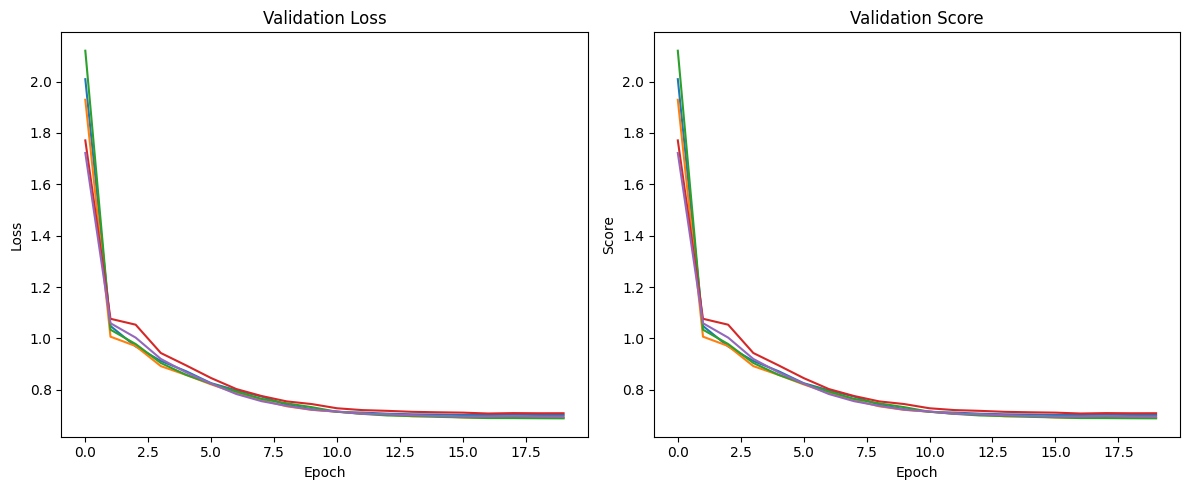

In [21]:
main()

# inference

In [22]:
class EnsembleModel:
    def __init__(self):
        self.models = []

    def __call__(self, x):
        outputs = []
        for model in self.models:
            if CFG.objective_cv == 'binary':
                outputs.append(torch.sigmoid(model(x)).to('cpu').numpy())
            elif CFG.objective_cv == 'multiclass':
                outputs.append(torch.softmax(
                    model(x), axis=1).to('cpu').numpy())
            elif CFG.objective_cv == 'regression':
                outputs.append(model(x).to('cpu').numpy())

        avg_preds = np.mean(outputs, axis=0)
        return avg_preds

    def add_model(self, model):
        self.models.append(model)


def test_fn(valid_loader, model, device):
    preds = []

    for step, (images) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)

        with torch.no_grad():
            y_preds = model(images)

        preds.append(y_preds)

    predictions = np.concatenate(preds)
    return predictions


def inference():
    test = pd.read_csv(CFG.comp_dataset_path +
                       'test_features.csv')

    test['base_path'] = CFG.comp_dataset_path + 'images/' + test['ID'] + '/'

    paths = []
    for base_path in test['base_path'].values:
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix
            paths.append(path)

    print(paths[:5])

    CFG.video_cache = make_video_cache(paths)

    print(test.head(5))

    valid_dataset = CustomDataset(
        test, CFG, transform=get_transforms(data='valid', cfg=CFG))
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    model = EnsembleModel()
    folds = [0] if CFG.use_holdout else list(range(CFG.n_fold))
    for fold in folds:
        _model = CustomModel(CFG, pretrained=False)
        _model.to(device)

        model_path = CFG.model_dir + \
            f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth'
        print('load', model_path)
        state = torch.load(model_path)['model']
        _model.load_state_dict(state)
        _model.eval()

        # _model = tta.ClassificationTTAWrapper(
        #     _model, tta.aliases.five_crop_transform(256, 256))

        model.add_model(_model)

    preds = test_fn(valid_loader, model, device)

    test[CFG.target_col] = preds
    test.to_csv(CFG.submission_dir +
                'submission_oof.csv', index=False)
    test[CFG.target_col].to_csv(
        CFG.submission_dir + f'submission_{CFG.exp_name}.csv', index=False)

In [23]:
inference()

['../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t-1.0.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t-0.5.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_220/image_t-1.0.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_220/image_t-0.5.png']
[255, 227, 199, 170, 142, 114, 85, 57, 29]


0it [00:00, ?it/s]

                                     ID      vEgo      aEgo  steeringAngleDeg  \
0  012baccc145d400c896cb82065a93d42_120  3.374273 -0.019360        -34.008415   
1  012baccc145d400c896cb82065a93d42_220  2.441048 -0.022754        307.860077   
2  012baccc145d400c896cb82065a93d42_320  3.604152 -0.286239         10.774388   
3  012baccc145d400c896cb82065a93d42_420  2.048902 -0.537628         61.045235   
4  01d738e799d260a10f6324f78023b38f_120  2.201528 -1.898600          5.740093   

   steeringTorque  brake  brakePressed  gas  gasPressed gearShifter  \
0            17.0    0.0         False  0.0       False       drive   
1           295.0    0.0          True  0.0       False       drive   
2          -110.0    0.0          True  0.0       False       drive   
3           189.0    0.0          True  0.0       False       drive   
4           -41.0    0.0          True  0.0       False       drive   

   leftBlinker  rightBlinker  \
0        False         False   
1        False        

/tmp/ipykernel_34009/610043316.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)['model']


load ../proc/baseline/outputs/atmacup_18_cnn_exp001/atmacup_18-models/resnet34d_fold1_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_exp001/atmacup_18-models/resnet34d_fold2_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_exp001/atmacup_18-models/resnet34d_fold3_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_exp001/atmacup_18-models/resnet34d_fold4_last.pth


  0%|          | 0/14 [00:00<?, ?it/s]